In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Overview
- In this notebook, we would like to build a predictive model to predict the likelihood of default which is a binary variable.
- First, we will check the validity of the dataset, which involves checking missing values, overall statistics of the dataset, categorical and numerical variables distribution.
- Then exploratory analysis will be performed, for example, correlation matrix for numeric variables to check if there exists multicollinearity,use tabulation to measure relationship between two categorical variables, etc.
- Restructure data to standard tabular format, select candidate models for classification
- Decide which evaluation metrics to use, choose the model that has the best performance, only performed two model construction, but there is space to build more/tune further.

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

Build a model to predict the likelihood of default, a model which can generalize to
other data points. The column to be predicted is `default payment next month`.


Put your code in a Jupyter notebook. Be sure to generously intersperse Markdown cells
in your notebook, in order to explain the steps you are taking and any assumptions you
are making (in words). Breaking down the larger task into smaller, more concrete steps
is just as important to us as your final trained model and performance metrics, as it
reveals your thought process!
For any functions that you write, please include clear and fleshed out docstrings. Also,
please attempt to adhere to PEP-8 code formatting standards throughout your
notebook.
There is no need to make slides to accompany your notebook. If you’re invited to a
virtual onsite, we’ll ask you to walk us through your modeling exercise, and you can
present your work directly from your notebook. (In this case -- but not in others -- your
audience will be sufficiently code-savvy to respond well to this form of presentation.)
If you have any questions about this exercise, feel free to ask. But we encourage you to
try answering them yourself. **How you choose to interpret this task gives us additional
insight into your thinking. Also, you’ll notice that for a few of the columns in the dataset,
some commonly occurring values lack definitions in the documentation; we are
interested in seeing how you deal with this incompleteness of information.
Finally, once you have trained your model, please think of ways its predictions can be
used in Credit Sesame’s product. Be prepared to have a conversation about your
envisioned use cases.**

## Load Data
- https://archive-beta.ics.uci.edu/dataset/350/default+of+credit+card+clients
- We skipped the first row since it is a redundant row for column names

In [3]:
data = pd.read_excel("default of credit card clients.xls",skiprows=1)

In [4]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
data.shape

(30000, 25)

In [6]:
#no missing values for this dataset
data.isnull().mean()

ID                            0.0
LIMIT_BAL                     0.0
SEX                           0.0
EDUCATION                     0.0
MARRIAGE                      0.0
AGE                           0.0
PAY_0                         0.0
PAY_2                         0.0
PAY_3                         0.0
PAY_4                         0.0
PAY_5                         0.0
PAY_6                         0.0
BILL_AMT1                     0.0
BILL_AMT2                     0.0
BILL_AMT3                     0.0
BILL_AMT4                     0.0
BILL_AMT5                     0.0
BILL_AMT6                     0.0
PAY_AMT1                      0.0
PAY_AMT2                      0.0
PAY_AMT3                      0.0
PAY_AMT4                      0.0
PAY_AMT5                      0.0
PAY_AMT6                      0.0
default payment next month    0.0
dtype: float64

#### check categorical variables

In [7]:
data[['SEX', 'EDUCATION', 'MARRIAGE']].describe()

,SEX,EDUCATION,MARRIAGE
count,30000.000000,30000.000000,30000.000000
mean,1.603733,1.853133,1.551867
std,0.489129,0.790349,0.521970
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000
max,2.000000,6.000000,3.000000


From the data description, we know that education usually take values 1-4, however we observed some 0, 5 and 6 in the dataset. Since 5, 6 both represent unknown and 0 is uncategorized, let's combine them together as 4 "others", we assume that 0, 5, 6 should have similar characters as 4.

In [8]:
data['EDUCATION'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

In [9]:
data.loc[(data['EDUCATION']==0)|(data['EDUCATION']==5)|(data['EDUCATION']==6),"EDUCATION"]=4

Similarly, we can check the marriage column and see if we can combine any classes, 0 is undocumented so we can merge it with 3: others, assuming that these people are similar in marriage status.

In [10]:
data["MARRIAGE"].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [11]:
data.loc[data["MARRIAGE"] == 0, "MARRIAGE"] = 3

Let's take a look at columns that represent whether the payment for a specific month is on time or delayed. Seems like there are negative values, since 0 indicates paid ontime, and positive numbers indicate delays, **we will assume -1 and -1 also indicate the payment is ontime, and will combine these two categories with zero.**

In [12]:
data[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].describe()

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100
std,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988
min,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000


In [13]:
data['PAY_0'].value_counts() 

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_0, dtype: int64

In [14]:
data.loc[(data["PAY_0"] == -2) | (data["PAY_0"] == -1) | (data["PAY_0"] == 0), 'PAY_0'] = 0
data.loc[(data["PAY_2"] == -2) | (data["PAY_2"]== -1) | (data["PAY_2"] == 0), 'PAY_2'] = 0
data.loc[(data["PAY_3"] == -2) | (data["PAY_3"] == -1) | (data["PAY_3"]== 0), 'PAY_3'] = 0
data.loc[(data["PAY_4"] == -2) | (data["PAY_4"] == -1) | (data["PAY_4"] == 0), 'PAY_4'] = 0
data.loc[(data["PAY_5"] == -2) | (data["PAY_5"] == -1) | (data["PAY_5"] == 0), 'PAY_5'] = 0
data.loc[(data["PAY_6"] == -2) | (data["PAY_6"] == -1) | (data["PAY_6"] == 0), 'PAY_6'] = 0

**Check other numerical variables**

In [15]:
# Bill amount
data[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


**There are negative values of the bill amount, we can interpret them as credit and not impute or change their values.**

In [16]:
#Previous payment amount
data[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


The minimum payment amount is zero, which makes sense.

## EDA

In [17]:
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

#### First we are interested in the distribution of our target variable, so let's check the number of default vs non-default

<AxesSubplot:ylabel='default payment next month'>

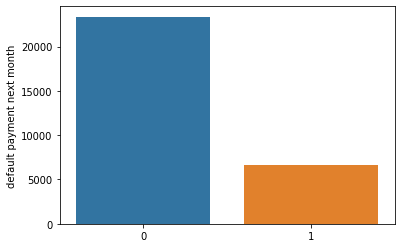

In [18]:
sns.barplot(x=data['default payment next month'].value_counts().index,y=data['default payment next month'].value_counts())

Based on the above bar chart, we see that there is a strong imbalance between non-default and default payments, therefore when doing predictions we need to take into account the imbalance.

Let's take a look at some other features, and:
1. Credit limit
2. Bill amount per month
3. Payment amount per month
4. Categorical Vaiables

### We can define a function to plot categorical variables and numerical variables agains default payment status since we have quite many different variables.

In [19]:
def plot_variables(var1, hue = 'default payment next month', var2 = None, typ="numeric"):
    '''Plot histogram for single variable agains default payment or plot boxplot for one categorical
    and on numerical variable
    var1: the variable we would like to study against default payment, can be numeric or categorical
    hue: column to group by when performing visualization, default is default payment next month
    var2: optional variable if we would like to study three variables together, would have to be numeric since 
    we will do boxplots
    typ: if var1 is numeric, we plot histogram, if var1 is categorical we do cross tabulation and do bar plot
    '''
    if not var2:
        if typ == "numeric":
            sns.histplot(x=var1, hue = hue, data=data)
        else:
            groupdf = data.groupby([var1, hue]).size().unstack()
            groupdf.plot(kind='bar')
            
    else:
        sns.catplot(data=data, x=var1, y=var2, hue=hue, kind="box")

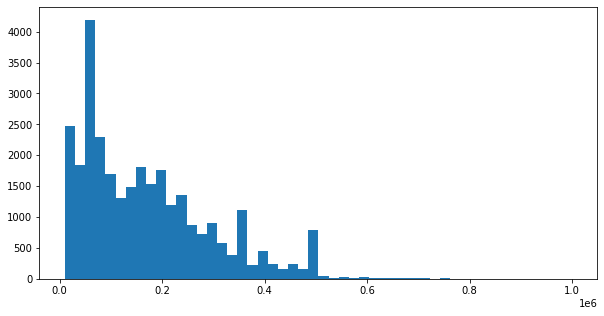

In [20]:
plt.figure(figsize = (10,5))
p = plt.hist(data['LIMIT_BAL'],bins=50)

Above shows the overall distribution of credit limit, where we see most limits are within 40000. Now we will plot credit limit balance by default payment.

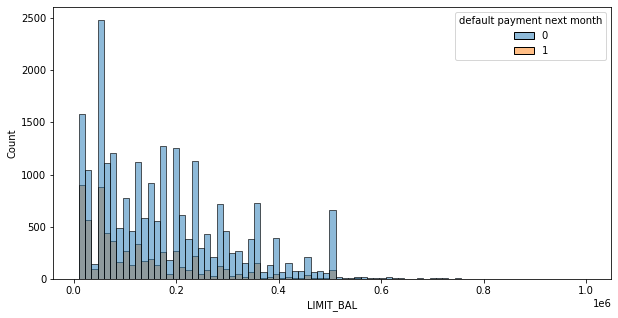

In [21]:
plt.figure(figsize = (10,5))
plot_variables("LIMIT_BAL")

By plotting the credit balance by default payment, we see that those who default are more concentrated toward the left (smaller than 40000) compared with those who paid on time.

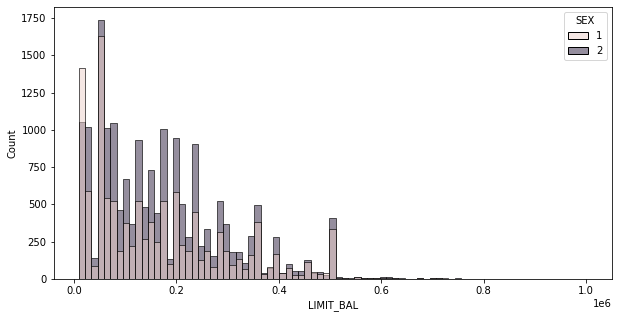

In [22]:
#plot histogram of credit limit against sex
plt.figure(figsize = (10,5))
plot_variables("LIMIT_BAL",hue="SEX")

Credit limits are quite balanced among sex, might have sligh differences in distribution and outliers.

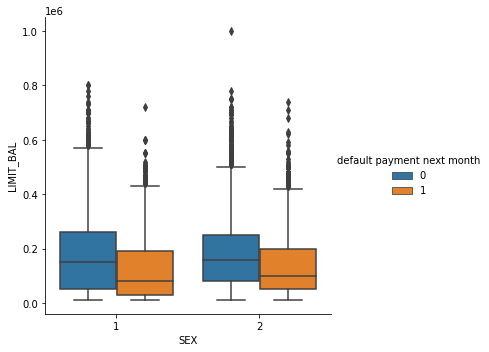

In [23]:
#plot credit limit vs sex, by default payment
plot_variables("SEX",hue ='default payment next month', var2 = 'LIMIT_BAL' )

After separating them by default payment, we observed that for both male and female, those who default have a lower median credit limits, this is aligned with the histogram of credit limit we showed above. And for male, the spread (based on IQR) is larger than female, so sex and credit limit can be helpful in predicting likelihood of default

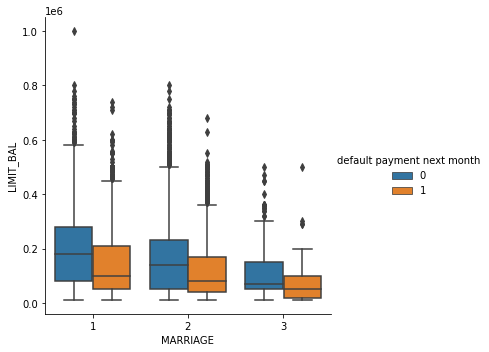

In [24]:
#plot credit limit vs sex, by default payment
plot_variables("MARRIAGE",hue ='default payment next month', var2 = 'LIMIT_BAL'  )

Similar to sex, we observed that those who default have lower median credit limit, regardless of which stage is the marriage, and for married people, credit limits are highest, then single, then for group others, so others might be indicating people who divorced, etc.

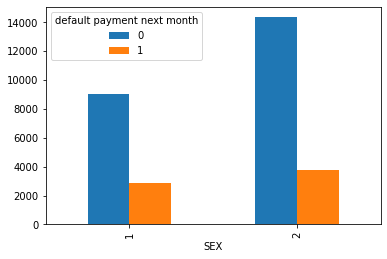

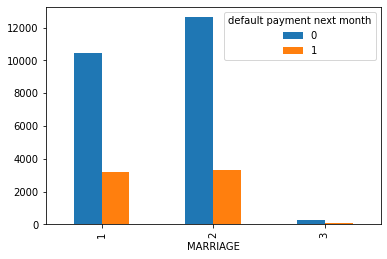

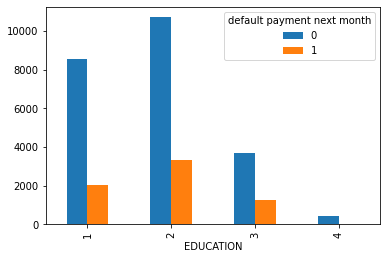

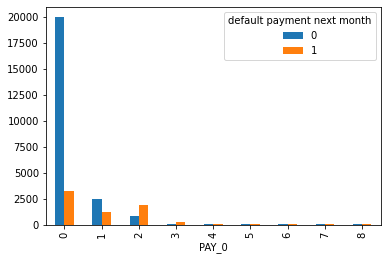

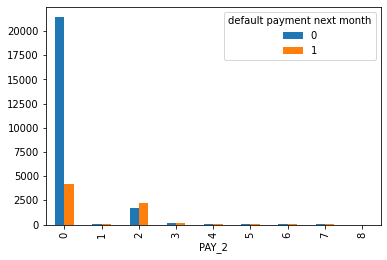

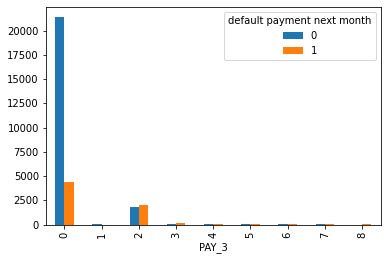

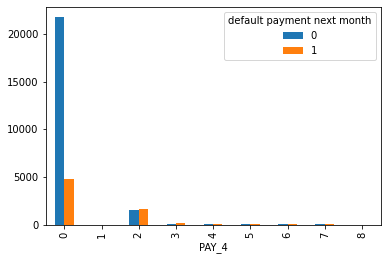

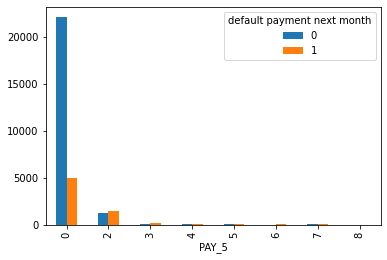

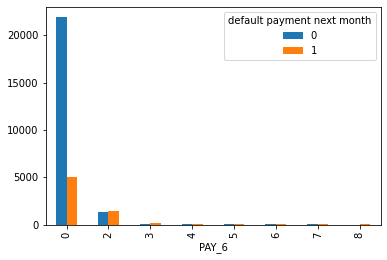

In [25]:
# here we zoom into relationship between three categorical variables AND 6 ordinal variables and default
for col in ["SEX","MARRIAGE","EDUCATION","PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]:
    plot_variables(col,hue ='default payment next month', typ="categorical")

Based on the height of the default bars, we concluded that women, single and university graduates tend to have more numbers of defult, however, ratio wise, it seems like male, married and high school graduate have higher probability of defaults. And for repayment status, starting from delay two months or more, we can start to observe number of defaults could potentially exceed number of non-defaults.

**Let's focus on other numeric variables**

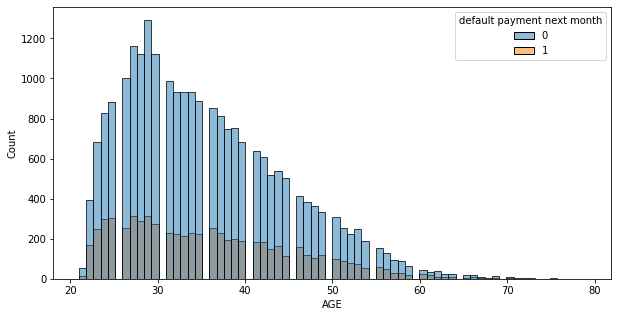

In [26]:
#age
plt.figure(figsize = (10,5))
plot_variables("AGE")

Distribution of default people are flatter, but for both default types, we observed there is a higher number of people around younger people (age 20-30s), but the proportion of default seems to be larger for older people.

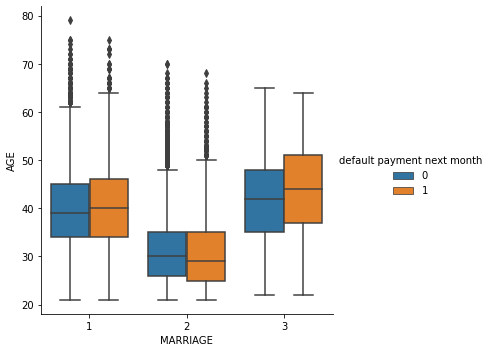

In [27]:
#plot age vs marriage, by default payment
plot_variables("MARRIAGE",hue ='default payment next month', var2 = 'AGE' )

We observed that for married and other group, we have default people having larger ages on average, while for single, we have slightly lower age for default people. Which seems to make sense because for younger people, we might pay less attention on spending and credit balance, and for married and other people, economic or other situation affecting default payment tend to increase as we progress later in our life. So combination of marriage status and age will be helpful in predictin likelihood.

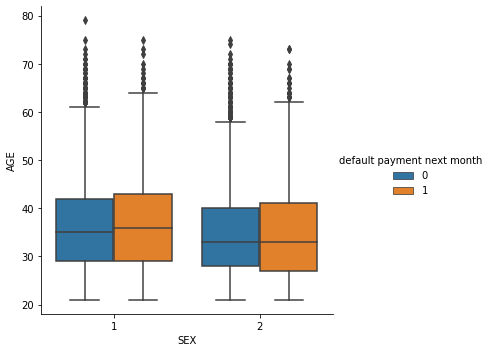

In [28]:
#plot age vs sex, by default payment
plot_variables("SEX",hue ='default payment next month', var2 = 'AGE' )

For both genders, median age seems to be slightly higher for default

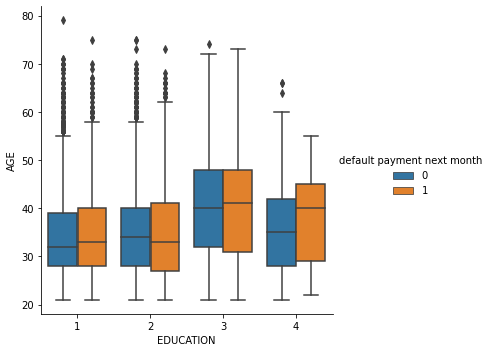

In [29]:
#plot credit limit vs sex, by default payment
plot_variables("EDUCATION",hue ='default payment next month', var2 = 'AGE' )

Age for default is higher for graduate school, high school and other, but lower for university grads, and age is significantly higher for default in the group "other", and older people might have shorter education (indicated by high school or other)

In addition, we will focus on bill amount and payment amount as by intuition we belive that these two should be really close to each other.

<AxesSubplot:>

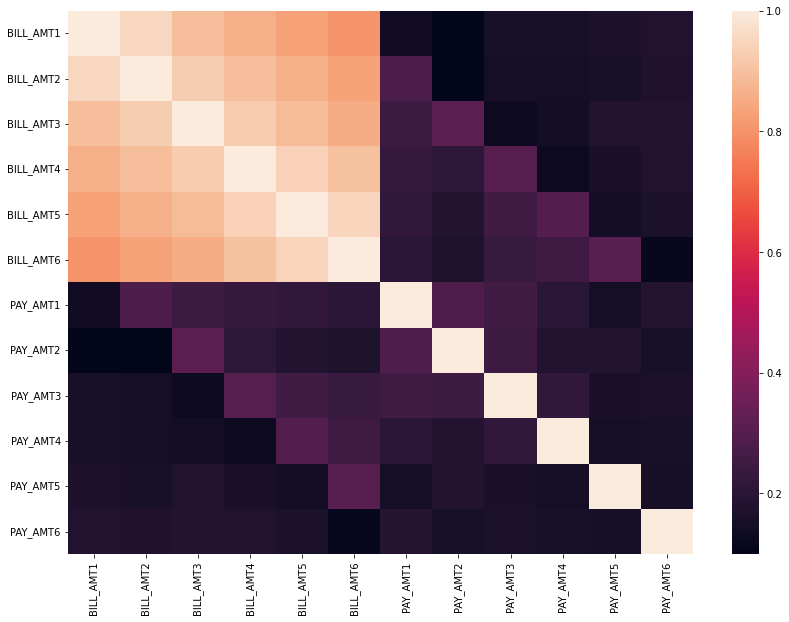

In [30]:
columns = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']
plt.figure(figsize=(14,10))
corr = data[columns].corr()
sns.heatmap(corr,xticklabels=corr.columns)

As months become further apart, we observe smaller correlation. And correlation between bill amount and payment amount are not strong, so we would include both in our model.

## Model Construction
Based on our previous data exploration, we see that each categorical variable or numerical variable do have some indication of default status, but not necessarily in a linear way, therefore, we will first use a random forest classifier to predict the likelihood, and then see if boosting can reduce bias even further.

### Evaluation Metric
For this problem I will use area under curve as my primary metric, since we focus on probability of payment, we will not have a defined threshold, so precision or recall would be deterministic and not flexible, area under the curve can provide us information on how the model performs across different probability thresholds.

In [31]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [32]:
X = data.drop(["ID",'default payment next month'],axis=1)

Some categorical variables need one-hot encoding, since they do not have strong ordinal meanings, unlike payment status where month 1 is different than month 8. We use pandas to get dummy variables.

In [33]:
cat_cols= ['EDUCATION', 'SEX', 'MARRIAGE']
X = pd.get_dummies(X, columns = cat_cols)

In [34]:
y = data['default payment next month']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [36]:
rf = RandomForestClassifier()

In [37]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [38]:
# make binary predictions to use ROC as metric
predictions = rf.predict(X_test)

In [39]:
roc_auc_score(y_test, predictions)

0.6536659923879689

Area under curve is 0.65, which is better than a random classifier, lets generate the probabilities which in the context of random forest are equal to the proportion of votes.

In [40]:
pred_probs = rf.predict_proba(X_test)

In [41]:
# the second column is the probability of default
pred_probs

array([[0.76, 0.24],
       [0.94, 0.06],
       [0.68, 0.32],
       ...,
       [0.93, 0.07],
       [0.78, 0.22],
       [0.94, 0.06]])

Let's take a look at feature importance to see which features are most important

[Text(0, 0, 'PAY_0'),
 Text(1, 0, 'AGE'),
 Text(2, 0, 'BILL_AMT1'),
 Text(3, 0, 'LIMIT_BAL'),
 Text(4, 0, 'BILL_AMT2'),
 Text(5, 0, 'BILL_AMT3'),
 Text(6, 0, 'BILL_AMT4'),
 Text(7, 0, 'PAY_AMT1'),
 Text(8, 0, 'BILL_AMT6'),
 Text(9, 0, 'BILL_AMT5'),
 Text(10, 0, 'PAY_AMT2'),
 Text(11, 0, 'PAY_AMT3'),
 Text(12, 0, 'PAY_AMT6'),
 Text(13, 0, 'PAY_AMT4'),
 Text(14, 0, 'PAY_AMT5'),
 Text(15, 0, 'PAY_2'),
 Text(16, 0, 'PAY_3'),
 Text(17, 0, 'PAY_5'),
 Text(18, 0, 'PAY_6'),
 Text(19, 0, 'PAY_4'),
 Text(20, 0, 'EDUCATION_2'),
 Text(21, 0, 'SEX_2'),
 Text(22, 0, 'SEX_1'),
 Text(23, 0, 'EDUCATION_1'),
 Text(24, 0, 'MARRIAGE_2'),
 Text(25, 0, 'MARRIAGE_1'),
 Text(26, 0, 'EDUCATION_3'),
 Text(27, 0, 'MARRIAGE_3'),
 Text(28, 0, 'EDUCATION_4')]

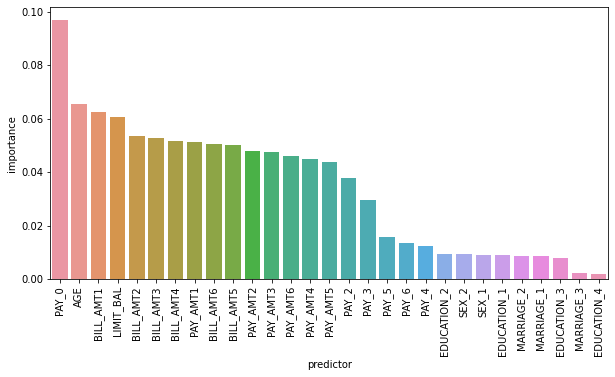

In [42]:
tmp = pd.DataFrame({'predictor': X.columns, 'importance': rf.feature_importances_})
tmp = tmp.sort_values(by='importance',ascending=False)
plt.figure(figsize = (10,5))
p = sns.barplot(x='predictor',y='importance',data=tmp)
p.set_xticklabels(p.get_xticklabels(),rotation=90)   

Based on this plot, PAY_0, which is the repayment status in September 2005 is the most important, which makes sense since as time frame gets closer, previous behavior is more likely to affect future behaviors. Age and credit limit is also shown to be important, which match our exploration where older people might have larger likelihood to default, and people with lower credit limit have higher proportion of default.

### Another model: xgboost
Boosting is well known to reduce bias, we can build an xgboost model and see if it can improve performance.

In [43]:
xgb = XGBClassifier(n_estimators=300, nthread=-1,max_depth=2,
       objective='binary:logistic',eval_metric="auc", subsample=0.8)

In [44]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, nthread=-1, num_parallel_tree=None,
              predictor=None, ...)

In [45]:
xgb_preds = xgb.predict(X_test)

In [46]:
roc_auc_score(y_test, xgb_preds)

0.6551021365832146

[Text(0, 0, 'PAY_0'),
 Text(1, 0, 'PAY_2'),
 Text(2, 0, 'PAY_3'),
 Text(3, 0, 'PAY_4'),
 Text(4, 0, 'PAY_5'),
 Text(5, 0, 'EDUCATION_4'),
 Text(6, 0, 'PAY_6'),
 Text(7, 0, 'MARRIAGE_2'),
 Text(8, 0, 'LIMIT_BAL'),
 Text(9, 0, 'MARRIAGE_1'),
 Text(10, 0, 'EDUCATION_1'),
 Text(11, 0, 'PAY_AMT1'),
 Text(12, 0, 'EDUCATION_2'),
 Text(13, 0, 'PAY_AMT2'),
 Text(14, 0, 'PAY_AMT3'),
 Text(15, 0, 'PAY_AMT4'),
 Text(16, 0, 'BILL_AMT1'),
 Text(17, 0, 'BILL_AMT3'),
 Text(18, 0, 'BILL_AMT2'),
 Text(19, 0, 'PAY_AMT5'),
 Text(20, 0, 'SEX_1'),
 Text(21, 0, 'PAY_AMT6'),
 Text(22, 0, 'BILL_AMT4'),
 Text(23, 0, 'BILL_AMT6'),
 Text(24, 0, 'BILL_AMT5'),
 Text(25, 0, 'AGE'),
 Text(26, 0, 'EDUCATION_3'),
 Text(27, 0, 'MARRIAGE_3'),
 Text(28, 0, 'SEX_2')]

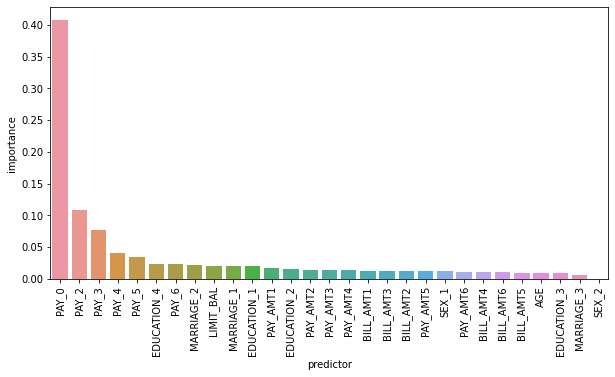

In [47]:
tmp = pd.DataFrame({'predictor': X.columns, 'importance': xgb.feature_importances_})
tmp = tmp.sort_values(by='importance',ascending=False)
plt.figure(figsize = (10,5))
p = sns.barplot(x='predictor',y='importance',data=tmp)
p.set_xticklabels(p.get_xticklabels(),rotation=90)   

Our initial version of xgb model increases AUC slightly, and feature importance shows more significant weight on PAY_0, which is aligned with random forest result that previous month behavior is very indicative of potential behavior next month. We don't have enough time to tune the xgb model, given many parameters and capabilities of xgb models, we can further perform grid search or k fold cross validation to choose the set of parameters that perform best on the testing set.

## Conclusion and Next Steps
1. Based on our data exploration and result of the probability model, we concluded that demographic variables of customers as well as payment behaviors are important factors that could potentially impacted likelihood of default payment next month.
2. There are other potential features we could include that might enhance our accuracy of predictions, for example, purchase behaviors (last purchase amount, number of purchases per month, average purchase amount, etc), and other demographic information such as the household information the person is located in, income level, employment status  etc. If we could get more information, our predictions could potentially improve.
3. We can also explore combinations of features, for example find a non linear way to combine credit limit, age and education might make the feature more correlated with our target variable than associate them separately.
4. There can be several use cases for the predictions of the model:\
    a. The predicted likelihood can be incorporated into products like card recommendations for users, if there is a high default probability, the credit score of the user probably would not look good and thus has a lower probability of getting certain credit cards approved, therefore when recommending cards, we should give lower ranking for that  specific cards if the user is likely to default.\
    b. Another use case is toward customers. We can incorporate this information into their credit score reports and credit monitoring, sending alerts to users who are likely to default, and provide some suggestions to prevent further decrease of credit scores.\
    c. A third use case is that we could incorporate this likelihood with credit builders, when a customer tends to default, we can add features to increase number of users of the credit builders, which would increase visibility of our products also user profile of the product.
